# Study the Distribution of Residual

In [1]:
include("utility.jl")
include("RPCA_SolverV.jl")
using PyPlot
using Optim

## Load Data

In [2]:
m,n = 20480, 202;  # size of matrix
mp, np = 128,160;   # size of one image

(128,160)

In [3]:
fid = open("LS.bin","r");
L   = read(fid,Float64,m*n);
S   = read(fid,Float64,m*n);
close(fid);
fid = open("Campus/trees_float.bin","r");
A   = read(fid, Float64, m*1439);
close(fid);
A   = reshape(A,m,1439);
A   = A[:,[collect(1:200);1384;1385]]; # sub set
A   = A[:];

In [4]:
R = L - A;
# fid = open("R.bin","w");
# write(fid,R);
# close(fid);

## Define Experience CDF function

In [5]:
function eCDF(x::Array{Float64,1},R::Array{Float64,1})
    sort!(x)
    n = length(x)
    m = length(R)
    v = zeros(n)
    j = 1
    for i = 1:n
        while j ≤ m && R[j] < x[i]
            j += 1
        end
        v[i] = (j-1)/m
    end
    return v
end

eCDF (generic function with 1 method)

In [6]:
function κCDF(x::Array{Float64,1},κ,σ) # with variance
    sort!(x)
    n = length(x)
    v = zeros(n)
    c = 2.0*exp(-0.5*κ^2)/κ + sqrt(2.0*pi)*erf(κ/sqrt(2));
    for i = 1:n
        v[i] = cdfH(x[i]/σ,κ,c)
    end
    return v
end

κCDF (generic function with 1 method)

## Plot Result

In [7]:
x = collect(linspace(-0.5,0.5,100));
sort!(R);

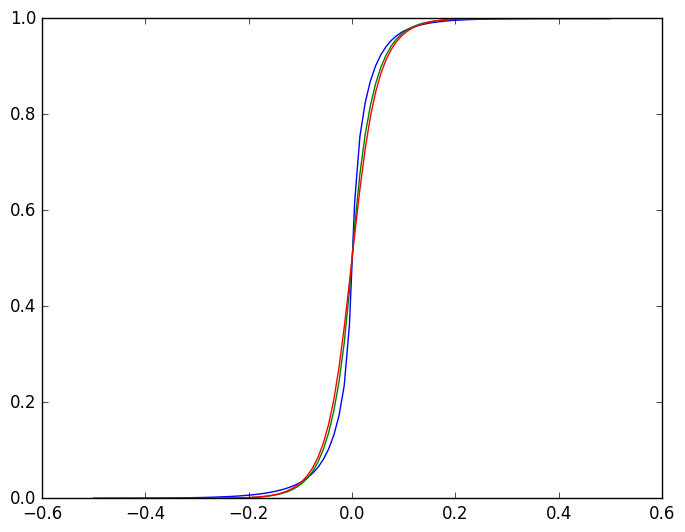

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327edbc90>

In [8]:
v1 = eCDF(x,R);
v2 = κCDF(x,0.1,0.0035);
v3 = κCDF(x,1.0,0.035);
plot(x,v1,"-b")
plot(x,v2,"-g")
plot(x,v3,"-r")

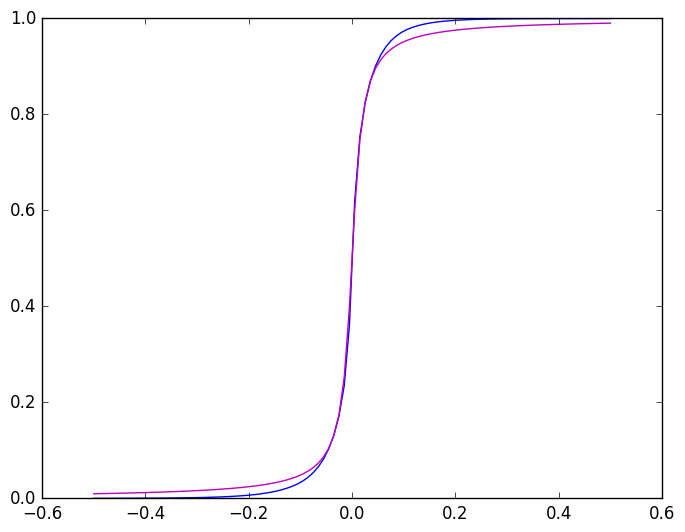

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327f23390>

In [9]:
# arctan
v4 = (atan(x*65) + pi/2)/pi
plot(x,v1,"b")
plot(x,v4,"m")

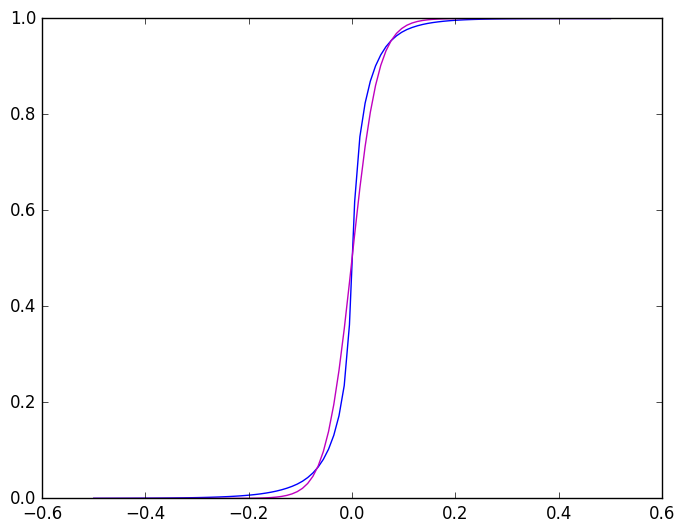

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3280b7ed0>

In [10]:
# sigmoid
v5 = 1./(1+exp(-x*40))
plot(x,v1,"b")
plot(x,v5,"m")

In [11]:
# ℓ₁ norm
function l1CDF(x,σ)
    n = length(x)
    v = zeros(n)
    for i = 1:n
        v[i] = ifelse(x[i] ≤ 0.0,0.5*exp(x[i]/σ),1.0 - 0.5*exp(-x[i]/σ))
    end
    return v
end

l1CDF (generic function with 1 method)

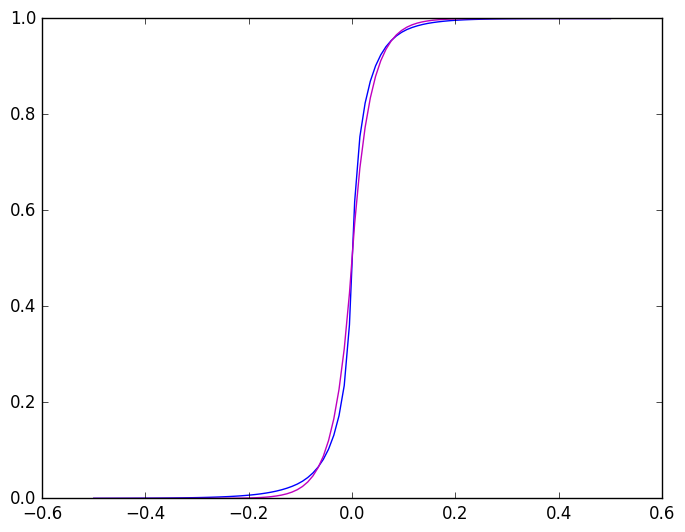

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328176c10>

In [12]:
v6 = l1CDF(x,0.032)
plot(x,v1,"b")
plot(x,v6,"m")

## Test If Projection with Variance Work

In [13]:
function objθ(θ,R)
    κ = θ[1];
    σ = θ[2];
    c = σ*(2.0*exp(-0.5*κ^2)/κ + sqrt(2.0*pi)*erf(κ/sqrt(2)));
    n = length(R);
    κσ = κ*σ;
    val = 0.0;
    for i = 1:n
        abs(R[i]) > κσ ? val += κ*abs(R[i])/σ - 0.5*κ^2 :
                         val += 0.5*(R[i]/σ)^2
    end
    val /= n
    val += log(c)
    return val
end

objθ (generic function with 1 method)

In [14]:
fid = open("R.bin","r");
R = read(fid,Float64,m*n);
close(fid)
α = sum(abs(R))/length(R);
κ = 1e-10;
σ = α*κ;
objθ([κ,σ],R)

-1.8251341485716175

## Recover S

In [15]:
κσ = 0.0;
S  = zeros(m,n);
r  = reshape(L-A,m,n);
for I in eachindex(S)
    r[I] >  κσ ? S[I] = r[I] - κσ :
    r[I] < -κσ ? S[I] = r[I] + κσ : continue;
end

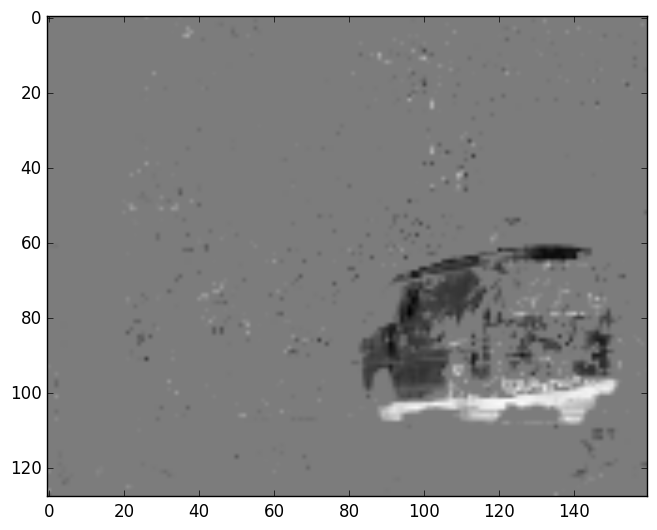

In [16]:
mp, np = 128,160;
imshow(reshape(S[:,201],mp,np), cmap="gray");